#### Pick last statements of customers for train and test both

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Read training data 
df_train_x = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()
# Read training data labels
df_train_y = pd.read_csv('D:/Sakshi/DSBA_6156_SERJ/data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()
df_train_y = df_train_y.set_index('customer_id')

df_train_x = df_train_x.sort_values(['customer_id', 's_2'])
df_train = pd.merge(df_train_x, df_train_y, on='customer_id')
del(df_train_x, df_train_y)

In [3]:
# # Before doing any transformation see the datatypes of the features
# df_train.dtypes.to_csv('../ignore/final/before_transformations.csv')

In [4]:
df_train['last_statement_flag'] = (df_train.groupby('customer_id')['s_2']
                      .rank(method='dense', ascending=False)
                      .astype(int)
                   )
df_train = df_train[df_train['last_statement_flag']== 1]                                      

In [5]:
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85']\
    [['customer_id','s_2','target','last_statement_flag']]

,customer_id,s_2,target,last_statement_flag
116,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-01,1,1


In [6]:
df_train.drop(columns = 'last_statement_flag', inplace=True)

In [7]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation.
# Also assign the column names in sequence in which it appars in the file  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116',
                     'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [8]:
# # Check the percentage of missing values
# null_series = df_train.isna().sum() / df_train.shape[0]
# null_series.to_csv('../ignore/final/column_null_values_prop.csv')
# del null_series

In [8]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_train[i].unique()}')

The unique values for column d_63 is [0 3 4 5 1 2]
The unique values for column d_64 is [ 0  2  3 -1]
The unique values for column d_66 is [-1  1]
The unique values for column d_68 is [ 6  3  5  4  2  1 -1]
The unique values for column b_30 is [ 0  1  2 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  7  5  6  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  2  3  6  4 -1]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [2 1]


In [9]:
print(f'The shape of the original file is:{df_train.shape}')

The shape of the original file is:(458913, 191)


In [10]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100, 2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist() 

        return self

    def transform(self, X):
        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + self.cols_to_drop + ['target', 'customer_id', 's_2']))

        # Impute the mean of the numeric columns
        for col in numeric_cols:
            # Check if the column has any null value, then only apply the imputation
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].mean())
                            
            # Scale
            mean = X[col].mean()
            std = X[col].std()
            if std > 0:
                X[col] = ((X[col] - mean) / std).astype('float32')

        X = X.drop(columns = self.cols_to_drop)

        return X

# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))

In [11]:
df_processed.isnull().values.any()

False

In [12]:
del (df_train)
print(f'After processing the shape is :{df_processed.shape}')

After processing the shape is :(458913, 173)


In [13]:
# Check the correlation for the numeric columns
df_corr = df_processed.drop(columns = categorical_cols + ['target','customer_id','s_2']).corr()
df_corr.to_csv("D:/Sakshi/DSBA_6156_SERJ/ignore/final/single_num_corr_results.csv")

In [14]:
from sklearn.linear_model import LinearRegression

def sklearn_vif(data):

    # initialize dictionaries
    result = {}

    # form input data for each exogenous variable
    exogs = data.columns.to_list()
    for exog in exogs:
        # print(exog)
        not_exog = [i for i in exogs if i != exog]
        # exog would be for which the VIF has to be calculated based on the combination of other columns
        X, y = data[not_exog], data[exog]  
        # extract r-squared from the fit
        r_squared = LinearRegression(n_jobs=12).fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        result[exog] = vif
    return result

vif_data1 = sklearn_vif(df_processed.drop(columns = categorical_cols + ['target','customer_id','s_2']))
# Convert the results from the dictionary to dataframe
df_vif = pd.DataFrame({
    'feature': vif_data1.keys(),
    'VIF': vif_data1.values()
})
del(vif_data1)
df_vif.to_csv("D:/Sakshi/DSBA_6156_SERJ/ignore/final/single_num_VIF_data_results.csv",index=False)

In [16]:
# df_vif = pd.read_csv("D:/Sakshi/DSBA_6156_SERJ/ignore/final/single_num_VIF_data_results.csv")

In [15]:
# Plainly drop all the columns with higher VIF values
df_processed.drop(columns = df_vif[df_vif['VIF']> 10]['feature'].to_list(), inplace=True)
print(f'The remaining columns of the data after dropping columns with high VIF : {df_processed.shape[1]}')

The remaining columns of the data after dropping columns with high VIF : 142


In [16]:
X, y = df_processed.drop(columns=['target','customer_id','s_2']), df_processed['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=2303, stratify = y)                                               

In [17]:
# Model
sm_logit1 = sm.Logit(y_train,X_train).fit()
print(sm_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.237577
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               367130
Model:                          Logit   Df Residuals:                   366991
Method:                           MLE   Df Model:                          138
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5846
Time:                        22:48:04   Log-Likelihood:                -87222.
converged:                       True   LL-Null:                   -2.0998e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_2           -0.8610      0.015    -58.051      0.000      -0.890      -0.832
d_39           0.3579      0.

In [18]:
del(df_processed)
# Remove the insignificant features and train the model again. I will keep the alpha level as 0.05
logit_pvalues = round(sm_logit1.pvalues,3)
high_pval_col = logit_pvalues.index[logit_pvalues > 0.05]

# Drop these columns
X = X.drop(columns = high_pval_col)
print(f'The columns remaining after removing insignificant ones : {X.shape}')
X_train, X_test,y_train, y_test= train_test_split(X, y, test_size=0.2,
                                                     random_state=2303, stratify = y)

# Model
sm_logit2 = sm.Logit(y_train,X_train).fit()
print(sm_logit2.summary())

The columns remaining after removing insignificant ones : (458913, 99)
Optimization terminated successfully.
         Current function value: 0.237659
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               367130
Model:                          Logit   Df Residuals:                   367031
Method:                           MLE   Df Model:                           98
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5845
Time:                        22:48:14   Log-Likelihood:                -87252.
converged:                       True   LL-Null:                   -2.0998e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_2           -0.8763      0.014    -

In [19]:
# Calculate the confusion matrix
prediction_probab = sm_logit2.predict(X_test)
prediction = list(map(round,prediction_probab))
confusion_matrix(y_test,prediction)

array([[63811,  4206],
       [ 5359, 18407]], dtype=int64)

Validation accuracy is: 0.8957868014773978
Logistic : ROC AUC = 0.956


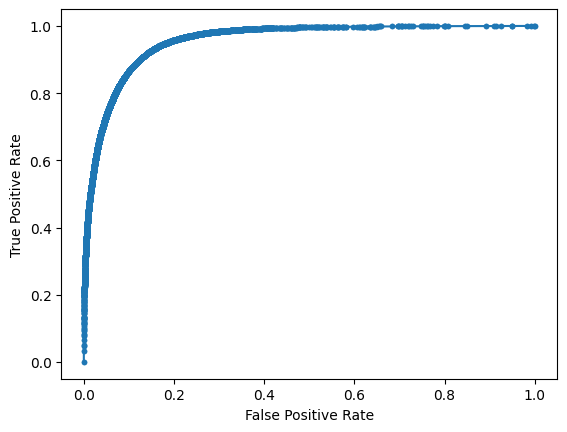

In [20]:
print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab)))

fpr,tpr,_ = roc_curve(y_test,prediction_probab)
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [21]:
# Clear the memory before loading the test data to predict
del(fpr,tpr,X_test,X_train,y_test,y_train,X,y,prediction,prediction_probab)

In [22]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not
    # fail --> these are the extra columns that we had in the training data
    extra_cols = ['target']
    print(df.shape)
    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df['target'] = np.zeros((df.shape[0], 1))
    print(df.shape)

    # Use the pipeline to transform
    X = pipeline.transform(df)
    print(X.shape)
    s = X.isnull().values.any()
    print(s)
    # Drop target & the insignificant variables found during the training using statsmodel p-value
    X.drop(columns=['target','customer_id','s_2'] + df_vif[df_vif['VIF']> 10]['feature'].to_list()
                    + high_pval_col.tolist(), inplace=True)

    # return log_reg.predict(X), log_reg.predict_proba(X)
    # In the statsmodel predict will give the probability
    return list(map(round,sm_logit2.predict(X))), sm_logit2.predict(X).tolist()
    

In [23]:
del(sm_logit1)
df_test = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/test.parquet')
df_test.columns= df_test.columns.str.lower()
df_test['last_statement_flag'] = (df_test.groupby('customer_id')['s_2']
                      .rank(method='dense', ascending=False)
                      .astype(np.int8)
                   )
df_test = df_test[df_test['last_statement_flag']== 1].copy()
df_test.drop(columns='last_statement_flag', inplace=True)

In [24]:
df_test.shape

(924621, 190)

In [25]:
# Define the result mdf
mdf = pd.DataFrame(columns=['customer_id', 's_2', 'pred', 'proba'])
y, y_proba = execute_model(df_test)

mdf = pd.concat([
    mdf,
    pd.DataFrame({
        'customer_id': df_test['customer_id'].values,
        's_2': df_test['s_2'].values,
        'pred': y,
        'proba': y_proba
    })
]) 
# mdf.to_csv('../ignore/final/logisticregression_baseline_prediction.csv', index=False)

(924621, 190)
(924621, 191)
(924621, 173)
False


In [26]:
mdf['s_2'] = pd.to_datetime(mdf['s_2'])
mdf['s_2'].dtype

dtype('<M8[ns]')

In [27]:
# Get the last statement probability of each of the customer
# df_result_last = mdf.sort_values(by = 's_2').groupby('customer_id')[['customer_id','proba']].tail(1)
mdf.rename(columns= {'proba' : 'prediction'},inplace=True)
mdf.to_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/logistic_baseline2_sub.csv', index=False)